### Systematic performance comparisons

Compare the following for recalibrating T5 cursor decoders:
- mean recalibration
- subspace realignment (optimized settings from `optimize_SubspaceRealignment.ipynb`)
- HMM (optimized settings from `optimize_vanillaHMM.ipynb`)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
import preprocess, sweep_utils
from plotting_utils import figSize
from lineplots import plotsd
from session_utils import *
from recalibration_utils import *
from click_utils import *

import sweep_utils
import resample

fig_path    = '/home/users/ghwilson/projects/nonstationarities/figures/'

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# run for training set 

DATA_DIR = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/T5/'
methods  = ['HMM', 'Stabilizer', 'HMM-Stabilizer']
params   = [['kappa', 'inflection', 'exp'], 
            ['model', 'n_components', 'B', 'thresh'],
            ['kappa', 'inflection', 'exp']]

pearson_r_thresh = 0.15**0.5
dataset          = 'BOTH'

scores = list()
fields = ['R2_score', 'pearson_r', 'days_apart', 'file', 'meanrecal_R2_score', 'meanrecal_pearson_r',
         'suprecal_R2_score', 'suprecal_pearson_r', 'norecal_R2_score', 'norecal_pearson_r',]

for m, p in zip(methods, params):
    
    if dataset == 'TRAIN':
        print('Loading training data.... \n')
        files = glob.glob(DATA_DIR + m + '/*sweep/*')
            
    elif dataset == 'TEST':
        print('Loading test data.... \n')
        files = glob.glob(DATA_DIR + m + '/test/*')
        
    elif dataset == 'BOTH':
        print('Loading train and test data... \n')
        files = glob.glob(DATA_DIR + m + '/*sweep/*')
        files.extend(glob.glob(DATA_DIR + m + '/test/*'))
    
    else:
        raise ValueError('dataset must be TRAIN or TEST')
        
        
    if m == 'HMM':
        prune = dict(zip(p, [2, 70, 0.5]))
    elif m == 'Stabilizer':
        prune = dict(zip(p, ['FactorAnalysis', 6, 160, 0.01]))
    elif m == 'HMM-Stabilizer':
        prune = None
    else:
        raise ValueError('Method not recognized')
        

    scores_df = sweep_utils.getSummaryDataFrame(files, p + fields, prune = prune)
    scores_df = scores_df[scores_df['meanrecal_pearson_r'] > pearson_r_thresh]
    scores_df = scores_df.sort_values(by = 'file', axis = 0).reset_index()
    scores.append(scores_df)

    #del scores_df  
    print(m, ' results loaded.')
    
    
assert [scores[i]['file'].equals(scores[i+1]['file']) for i in range(len(scores) - 1)], "Order mismatch"

Loading train and test data... 



../utils/preprocessing/sweep_utils.py:124: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  df = pd.concat(scores).reset_index()


HMM  results loaded.
Loading train and test data... 

Stabilizer  results loaded.
Loading train and test data... 

HMM-Stabilizer  results loaded.


In [3]:
paired_scores = dict()
paired_scores['file']        = scores[0]['file']
paired_scores['days_apart']  = scores[0]['days_apart']
paired_scores['meanrecal_pearson_r'] = scores[0]['meanrecal_pearson_r']
paired_scores['meanrecal_R2_score']  = scores[0]['meanrecal_R2_score']
paired_scores['norecal_pearson_r']   = scores[0]['norecal_pearson_r']
paired_scores['norecal_R2_score']    = scores[0]['norecal_R2_score']
paired_scores['suprecal_pearson_r']  = scores[0]['suprecal_pearson_r']
paired_scores['suprecal_R2_score']   = scores[0]['suprecal_R2_score']
 
# get scores for each approach
for method, score in zip(methods, scores):
    paired_scores[method + '_pearson_r'] = score['pearson_r']
    paired_scores[method + '_R2_score'] = score['R2_score']
    
# get score differences:
for method1, score1 in zip(methods, scores): 
    for method2, score2 in zip(methods, scores): 
        if method1 != method2:
            paired_scores[method1 + '_vs_' + method2] = score1['pearson_r'] - score2['pearson_r']

paired_scores = pd.DataFrame(paired_scores)

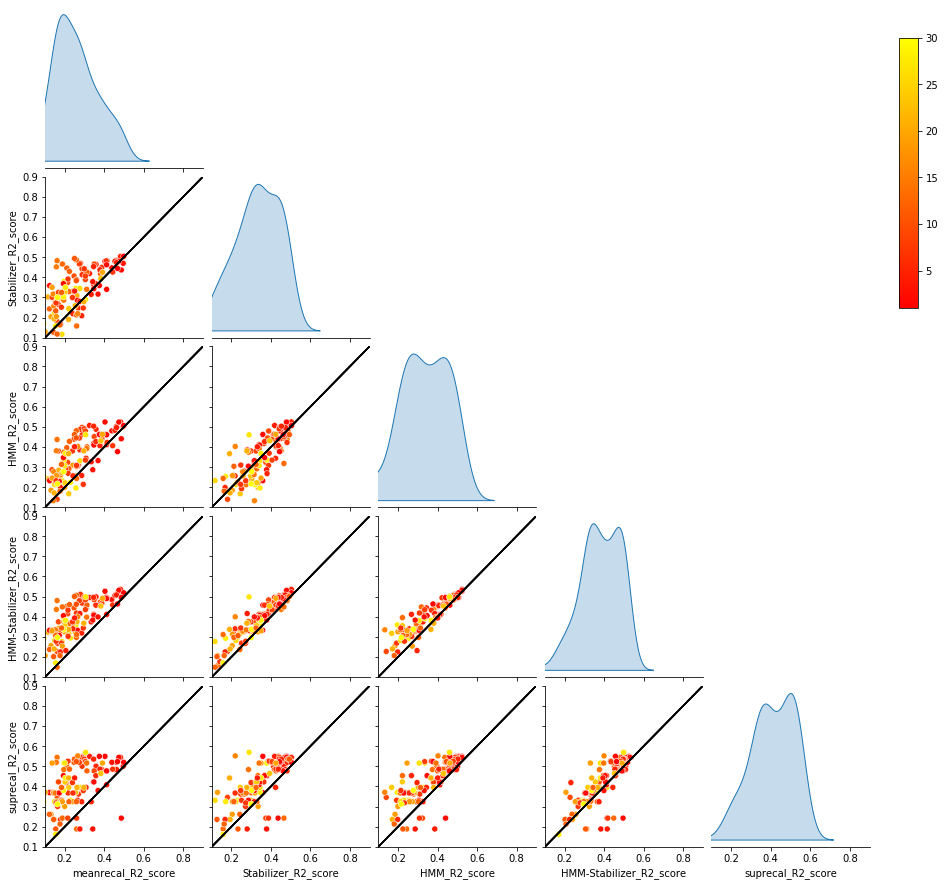

In [5]:
#figSize(10, 20)

figSize(5, 5)

metric = 'R2_score'
lims   = [0.1, 0.9]
cmap   = 'autumn'

fields = [x + metric for x in ['meanrecal_', 'Stabilizer_', 'HMM_', 'HMM-Stabilizer_', 'suprecal_']]

pp = sns.pairplot(paired_scores, vars = fields, 
                  hue = 'days_apart', corner = True, palette = cmap, 
                  diag_kws = {'hue' : None})
pp.set(xlim = lims)
pp.set(ylim = lims)

pp.legend.remove()
cax    = pp.fig.add_axes([.95, .65, .02, .3])
points = plt.scatter([], [], c= [], vmin = paired_scores['days_apart'].min(), 
                     vmax = paired_scores['days_apart'].max(), cmap = cmap)
pp.fig.colorbar(points , cax = cax, )

def addUnity(xdata, ydata, **kwargs):
    ax = plt.gca()
    ax.plot(lims, lims, color = 'k', alpha = 0.2)
    
pp.map_offdiag(addUnity)
colors = ['r', 'pink', 'blue', 'g']
#for i, ax in enumerate(pp.diag_axes):
#    col = ax.collections[0]
#    col.set_color(colors[i])
#    col.set_alpha(0.4)
    
plt.savefig(fig_path + f'/comparisons/{dataset}_pairplot', format = 'pdf')
plt.show()


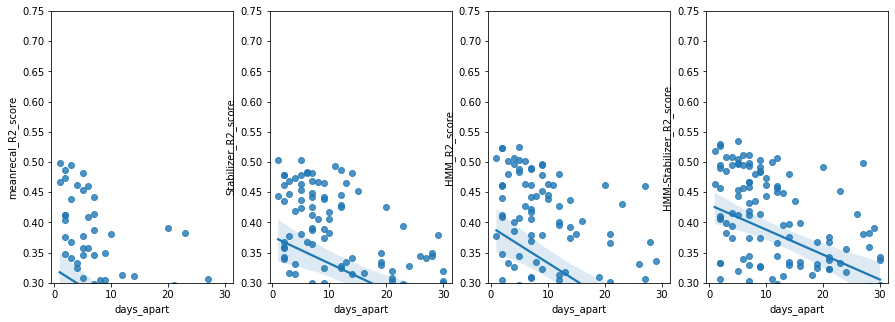

In [6]:
figSize(5, 15)

fields = [x + metric for x in ['meanrecal_', 'Stabilizer_', 'HMM_', 'HMM-Stabilizer_']]

for i, field in enumerate(fields):
    plt.subplot(1, 4, i + 1)
    out = sns.regplot(data = paired_scores, x = 'days_apart', y = field, ci= 95, n_boot = 1000)
    plt.ylim([0.3, 0.75])

plt.show()

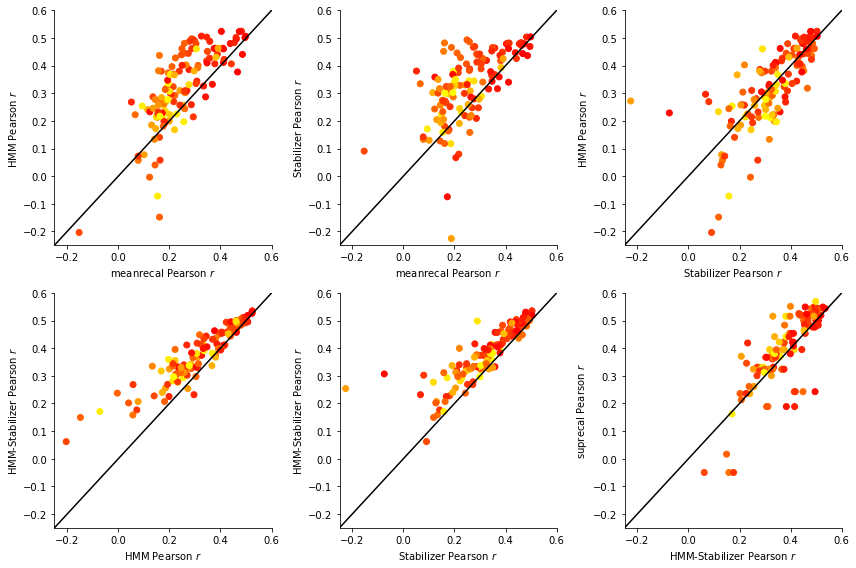

/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

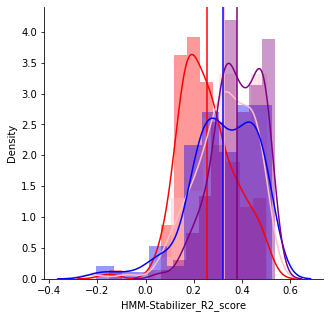

In [16]:
figSize(8, 12)

metric = 'R2_score'
lims   = [-0.25, 0.6]
cmap   = 'autumn'


pairs = [['meanrecal', 'HMM'], ['meanrecal', 'Stabilizer'], ['Stabilizer', 'HMM'],
        ['HMM', 'HMM-Stabilizer'], ['Stabilizer', 'HMM-Stabilizer'], ['HMM-Stabilizer', 'suprecal']]

for i, pair in enumerate(pairs):
    plt.subplot(2, 3, i + 1)
    plt.plot(lims, lims, color = 'k')
    plt.scatter(paired_scores[pair[0] + '_' + metric], paired_scores[pair[1] + '_' + metric], 
                c = paired_scores['days_apart'], cmap = cmap)
    plt.xlim(lims)
    plt.ylim(lims)m
    plt.xlabel(pair[0] + ' Pearson $r$')
    plt.ylabel(pair[1] + ' Pearson $r$')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.savefig(fig_path + f'/comparisons/{dataset}_scatters_{metric}', format = 'pdf')
plt.tight_layout()
plt.show()

figSize(5, 5)
plt.figure()

colors = ['r', 'pink', 'blue', 'purple']
for i, column in enumerate(['meanrecal_' + metric, 'Stabilizer_' + metric, 'HMM_' + metric, 'HMM-Stabilizer_' + metric]):
    sns.distplot(paired_scores[column], color = colors[i])
    plt.axvline(paired_scores[column].mean(), color = colors[i])    
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.savefig(fig_path + f'/comparisons/{dataset}_distplots_{metric}', format = 'pdf')
plt.show()

In [14]:
metric = 'R2_score'

fields = [x + metric for x in ['norecal_', 'meanrecal_', 'Stabilizer_', 'HMM_', 'HMM-Stabilizer_', 'suprecal_']]

for i, field1 in enumerate(fields):
    print('---------------', field1, '----------------')
    for j, field2 in enumerate(fields):
        if j > i:
            pval = scipy.stats.wilcoxon(paired_scores[field1], paired_scores[field2])
            print(field1, 'vs', field2, ':', pval)
            print('Difference (mean +- SD): ', np.mean(paired_scores[field1] - paired_scores[field2]),
                 '+-',  np.std(paired_scores[field1] - paired_scores[field2]))
            print('Number of instances worse than', field2, ':', sum((paired_scores[field1] - paired_scores[field2]) < 0),
                  '/', len(paired_scores[field1]))
            print('\n')

--------------- norecal_R2_score ----------------
norecal_R2_score vs meanrecal_R2_score : WilcoxonResult(statistic=697.0, pvalue=5.4232675000189245e-16)
Difference (mean +- SD):  -0.061443145927303135 +- 0.09586542090430823
Number of instances worse than meanrecal_R2_score : 104 / 127


norecal_R2_score vs Stabilizer_R2_score : WilcoxonResult(statistic=440.0, pvalue=2.7818257979143524e-18)
Difference (mean +- SD):  -0.1326431994910354 +- 0.13954840751828118
Number of instances worse than Stabilizer_R2_score : 116 / 127


norecal_R2_score vs HMM_R2_score : WilcoxonResult(statistic=407.0, pvalue=1.3753504000377086e-18)
Difference (mean +- SD):  -0.13070240343513037 +- 0.12848486928794703
Number of instances worse than HMM_R2_score : 117 / 127


norecal_R2_score vs HMM-Stabilizer_R2_score : WilcoxonResult(statistic=6.0, pvalue=1.6022828648549836e-22)
Difference (mean +- SD):  -0.1890558568833956 +- 0.12220368368628978
Number of instances worse than HMM-Stabilizer_R2_score : 125 / 127


n

Alternative - take into account time windows and overlapping session pairs:

In [9]:
deltas    = list()
windows   = [0, 7, 14, 31]
#windows   = [0, 14, 31]

week_subsets = list()

methods = ['meanrecal', 'Stabilizer', 'HMM', 'HMM-Stabilizer']

for i in range(len(windows) - 1):
    lower_lim   = windows[i]
    upper_lim   = windows[i+1]
    graph, idxs = resample.makeSessionPairGraph(paired_scores, lims = [lower_lim, upper_lim])
    subset      = idxs[resample.graphSets(graph)]
    subset_df   = paired_scores.iloc[subset]
    subset_df['week'] = np.zeros((subset_df.shape[0])) + i
    week_subsets.append(subset_df)
    
    print(i + 1, '/', len(windows) - 1)
    
week_subsets_df = pd.concat(week_subsets)

1 / 3
2 / 3
3 / 3


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/users/ghwilson/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

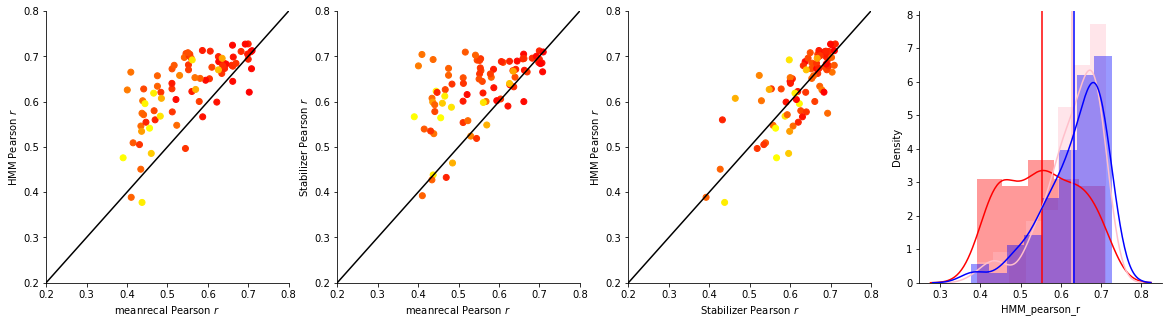

In [10]:
figSize(5, 20)

metric = 'pearson_r'
lims   = [0.2, 0.8]
cmap   = 'autumn'


pairs = [['meanrecal', 'HMM'], ['meanrecal', 'Stabilizer'], ['Stabilizer', 'HMM']]

for i, pair in enumerate(pairs):
    plt.subplot(1, 4, i + 1)
    plt.plot(lims, lims, color = 'k')
    plt.scatter(paired_scores[pair[0] + '_' + metric], paired_scores[pair[1] + '_' + metric], 
                c = paired_scores['days_apart'], cmap = cmap)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel(pair[0] + ' Pearson $r$')
    plt.ylabel(pair[1] + ' Pearson $r$')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.subplot(1, 4, 4)

colors = ['r', 'pink', 'blue']
for i, column in enumerate(['meanrecal_' + metric, 'Stabilizer_' + metric, 'HMM_' + metric]):
    sns.distplot(paired_scores[column], color = colors[i])
    plt.axvline(paired_scores[column].mean(), color = colors[i])    
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
#plt.savefig(fig_path + f'/comparisons/{dataset}_scatters', format = 'pdf')
plt.show()

Versus mean recalibration
==== week 0 ======
HMM : pval =  WilcoxonResult(statistic=1.0, pvalue=0.027991815485665747)
Difference (mean +- SD) 0.04123031339472377 +- 0.036973418207562204
Stabilizer : pval =  WilcoxonResult(statistic=3.0, pvalue=0.06297905121445523)
Difference (mean +- SD) 0.04827234899369609 +- 0.04534869986359906
==== week 1 ======
HMM

/share/software/user/open/py-scipy/1.4.1_py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


 : pval =  WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)
Difference (mean +- SD) 0.047629777239451686 +- 0.027203932874177487
Stabilizer : pval =  WilcoxonResult(statistic=5.0, pvalue=0.5001842570707944)
Difference (mean +- SD) 0.021439325545243082 +- 0.08975360015519136

 versus each other
==== week 0 ======
Stabilizer : pval =  WilcoxonResult(statistic=12.0, pvalue=0.7353166906373405)
Difference (mean +- SD) -0.007042035598972318 +- 0.0421537463295585
==== week 1 ======
Stabilizer : pval =  WilcoxonResult(statistic=6.0, pvalue=0.6858304344516057)
Difference (mean +- SD) 0.026190451694208604 +- 0.10480401003744047


/share/software/user/open/py-scipy/1.4.1_py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


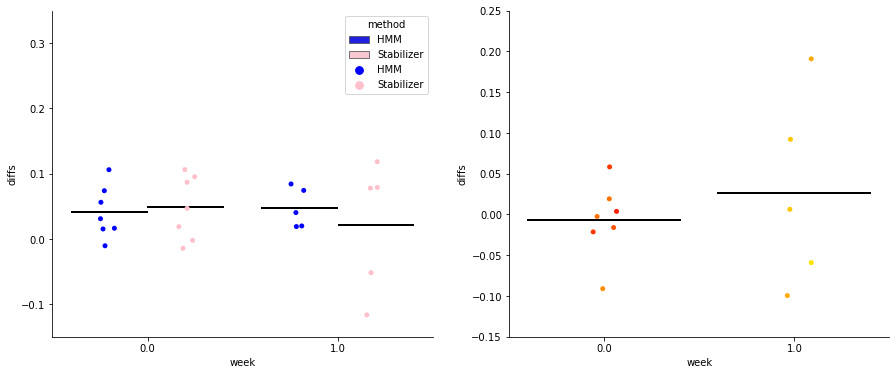

In [7]:
import sweep_utils

figSize(6, 15)

vs_meanrecal_lims = [-0.15, 0.35]
vs_eachother_lims = [-0.15, 0.25]



# HMM and stabilizer versus mean recalibration
plt.subplot(1, 2, 1)
diff1     = week_subsets_df['HMM_pearson_r'] - week_subsets_df['meanrecal_pearson_r']
diff2     = week_subsets_df['Stabilizer_pearson_r'] - week_subsets_df['meanrecal_pearson_r']

diffs  = np.concatenate([diff1, diff2])
method = np.concatenate([np.asarray('HMM').repeat(len(diff1)), np.asarray('Stabilizer').repeat(len(diff2))])
weeks  = np.tile(np.asarray(week_subsets_df['week']), 2)

plt_data = pd.DataFrame(zip(weeks, diffs, method), columns = ['week', 'diffs', 'method'])

print('Versus mean recalibration')
for week in range(len(windows) - 1):
    print('==== week', week, '======')
    for method in ['HMM', 'Stabilizer']:
        subset = sweep_utils.get_subsetDF(plt_data, {'week' : week, 'method' : method})
        pval   = scipy.stats.wilcoxon(subset['diffs'])
        print(method, ': pval = ', pval)
        print('Difference (mean +- SD)', np.mean(subset['diffs']), '+-', np.std(subset['diffs']))    
    
    

sns.stripplot(data = plt_data, x = 'week', y = 'diffs', hue = 'method', palette = ['blue', 'pink'], dodge=True)
sns.boxplot(data = plt_data, x = 'week', y = 'diffs', hue = 'method', palette = ['blue', 'pink'], dodge=True, 
            showmeans=True, meanline = True, meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            showcaps = False, showbox = False, showfliers=False,
            whiskerprops={'visible': False}, medianprops = {'visible' : False}, labels = None)

plt.ylim(vs_meanrecal_lims)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# HMM versus stabilizer 
plt.subplot(1, 2, 2)
method1 = 'HMM'
method2 = 'Stabilizer'

diff     = week_subsets_df[method1 + '_pearson_r'] - week_subsets_df[method2 + '_pearson_r']
plt_data = pd.concat([week_subsets_df["week"], diff, week_subsets_df['days_apart']], axis = 1,
                     keys = ['week', 'diffs', 'days_apart']).reset_index()

print('\n versus each other')
for week in range(len(windows) - 1):
    print('==== week', week, '======')
    subset = sweep_utils.get_subsetDF(plt_data, {'week' : week})
    pval   = scipy.stats.wilcoxon(subset['diffs'])
    print(method, ': pval = ', pval) 
    print('Difference (mean +- SD)', np.mean(subset['diffs']), '+-', np.std(subset['diffs']))   
    

sns.stripplot(data = plt_data, x = 'week', y = 'diffs', hue = 'days_apart', 
              palette = cmap)
sns.boxplot(data = plt_data, x = 'week', y = 'diffs', dodge=True, 
            showmeans=True, meanline = True, meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            showcaps = False, showbox = False, showfliers=False,
            whiskerprops={'visible': False}, medianprops = {'visible' : False}, labels = None)

plt.ylim(vs_eachother_lims)

ax = plt.gca()
ax.legend([],[], frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fig_path + f'/comparisons/{dataset}_weekbreakdown', format = 'pdf')
plt.show()

In [9]:
import stats

In [20]:
subset = sweep_utils.get_subsetDF(week_subsets_df, {'week' : 1})
_      = stats.pitman_morgan(subset['HMM_pearson_r'], subset['Stabilizer_pearson_r'], verbosity=1)

tval = 1.7550, df = 3.0, p = 0.1775
